# Clustering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import *
from sklearn.neighbors import kneighbors_graph
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

In [2]:
#Loading the dataframe
df = pd.read_pickle("./dataunderstanding.pkl")

## Choosing features for the analisys of Clustering

For a correct clustering analysis we decided to drop all categorical variables:

In [3]:
#Creating a dataframe by dropping columns not useful for analisys
dfnaf = df.drop(['length_ms','emotion','emotional_intensity', 'repetition', 'angry', 'calm', 'disgust',
                 'fearful', 'happy', 'neutral','sad', 'surprised',
                 'sex','vocal_channel'], axis =1)

## Data visualization with dimensionality reduction: PCA and TSNE

When we have dataset with a high dimensionality, using plots that allow us to see only two variables at time, would be time-consuming. Therefore we decided to plot all the features using PCA and t-SNE methods. Those two methods reduce the dimensionality and allow us to plot data. In addition, t-SNE keeps similar data points together. Before plotting, we normalized the dataset.

With PCA we can see a clear division between 'sing' and 'speech'

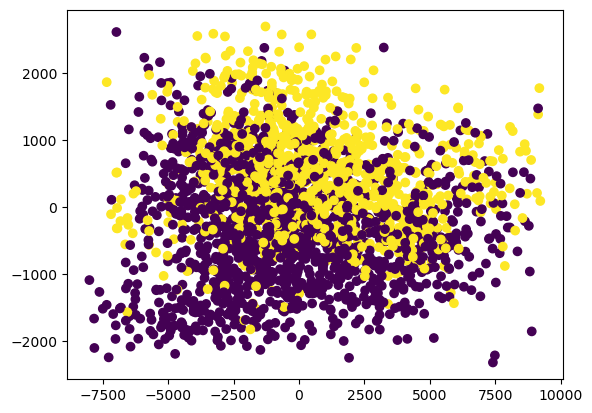

In [4]:
pca = PCA()
X_pca = pca.fit_transform(dfnaf.values)

#Visualization of PCA based on vocal_channel
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['vocal_channel'])
plt.show()

With TSNE we can see a clear division with respect to sex

In [5]:
#For utilizing TSNE we need to normalize the dataset
scaler = MinMaxScaler()
dfs = df[['intensity','zero_crossings_sum', 'mfcc_mean', 'mfcc_std', 'mfcc_min','mfcc_max',
          'sc_mean', 'sc_std', 'sc_min', 'sc_max', 'sc_kur', 'sc_skew',
          'stft_kur', 'stft_skew', 'max', 'kur', 'skew']]
dfs_val = dfs.values
dfs_tse = scaler.fit_transform(dfs_val)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(dfs_tse)

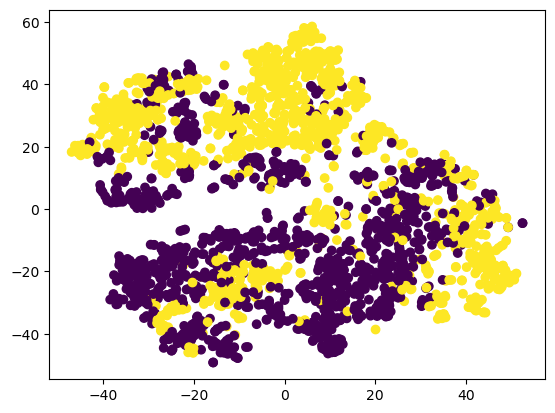

In [6]:
#Visualization of TSNE with respect to sex
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['sex'])
plt.show()

## Clustering Analysis by K-means

Before clustering we normalized the features to bring them to a similar scale, this passage is crucial because kmeans is distance-based and can be sensitive to the scale of the features. The identification of the best value of k was based on the best values of SSE and Silhouette Coefficient. We started analysing with k=10 for testing wich k was a better choise and then we decided to choose 6 clusters beacuse it had the higher silhouette and a relatively low SSE. We finally reported the visualization of clusters in dimensionality reduction through PCA and TSNE.

In [7]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(dfnaf)

/Users/ramiropredassi/anaconda3/envs/env_maser/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ramiropredassi/anaconda3/envs/env_maser/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ramiropredassi/anaconda3/envs/env_maser/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/ramiropredassi/anaconda3/envs/env_maser/lib/python3.11/site-packages/sklearn/utils/validation.py:767: Fu

In [8]:
#Creating a list of SSE for a different range of k
sse_list = []
for k in range(2, 30):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100, random_state = 0)
    kmeans.fit(train_data)
    sse_list.append(kmeans.inertia_)

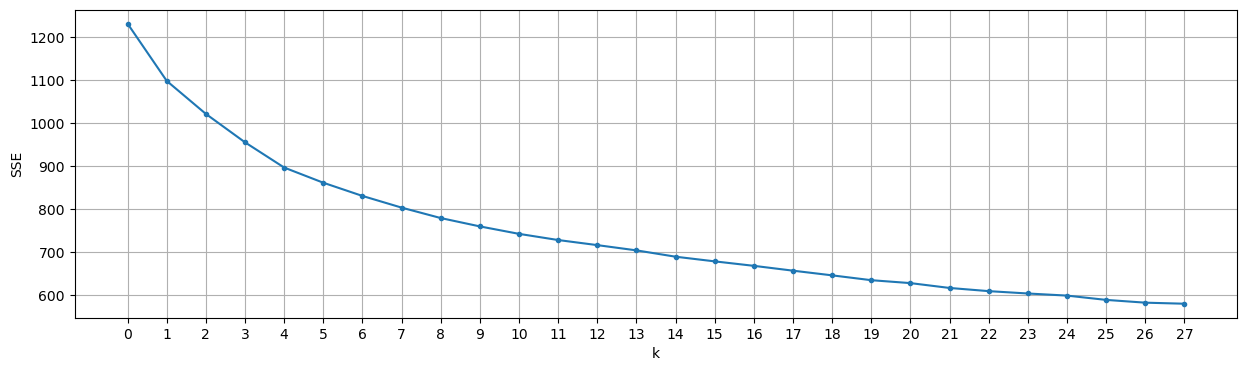

In [9]:
#Plotting the value of SSE for a different range of k
plt.figure(figsize=(15,4))
plt.plot(range(len(sse_list)), sse_list, marker='.')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(range(len(sse_list)))
plt.grid()
plt.show()

In [10]:
#Choosing k=10 to start
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10, max_iter=100, random_state=0)
kmeans.fit(train_data)
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(train_data, kmeans.labels_))

labels {0: 356, 1: 238, 2: 226, 3: 235, 4: 288, 5: 285, 6: 206, 7: 252, 8: 221, 9: 145}
sse 778.8343049921275
silhouette 0.12478588039833126


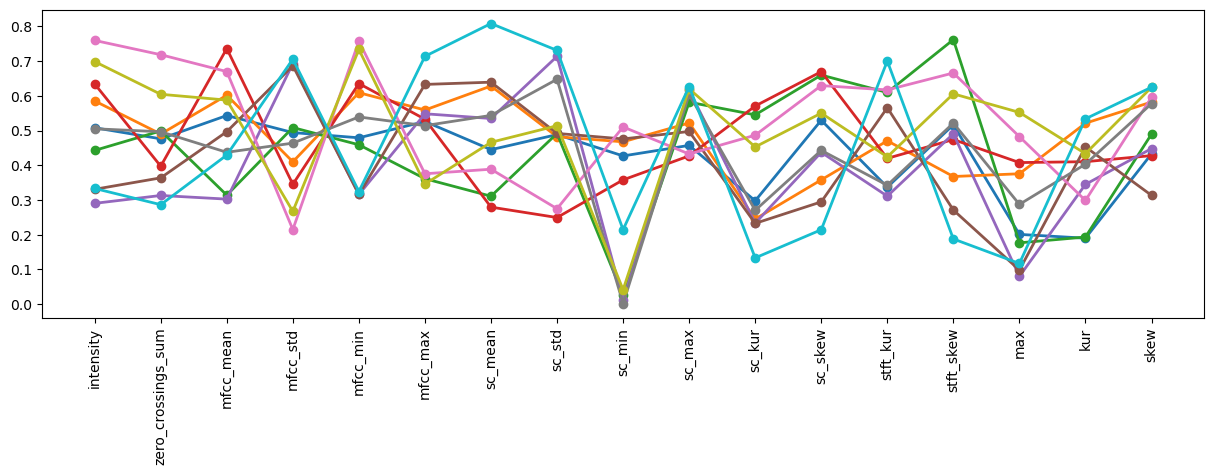

In [15]:
#Plotting the value of the normalized features for each cluster with a parallel coordinates graph
plt.figure(figsize=(15,4))
for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, 17), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=2, marker = 'o')
plt.xticks(range(0, 17), list(dfnaf.columns),rotation = 90)
plt.show()

In [16]:
#Size of each cluster
labels, sizes = np.unique(kmeans.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(dfnaf)))

Cluster 0, size 356 (0.15)
Cluster 1, size 238 (0.10)
Cluster 2, size 226 (0.09)
Cluster 3, size 235 (0.10)
Cluster 4, size 288 (0.12)
Cluster 5, size 285 (0.12)
Cluster 6, size 206 (0.08)
Cluster 7, size 252 (0.10)
Cluster 8, size 221 (0.09)
Cluster 9, size 145 (0.06)


In [17]:
#Evaluating Silhouette Coefficient using distances
D = squareform(pdist(train_data))
silhouette_score(D, kmeans.labels_, metric='precomputed')

0.12478588039833123

In [18]:
#Creation of a list of SSE and Silhouette Coefficient variting the value of k
sse_list = list()
sil_list = list()
max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(train_data)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(D, kmeans.labels_, metric='precomputed'))

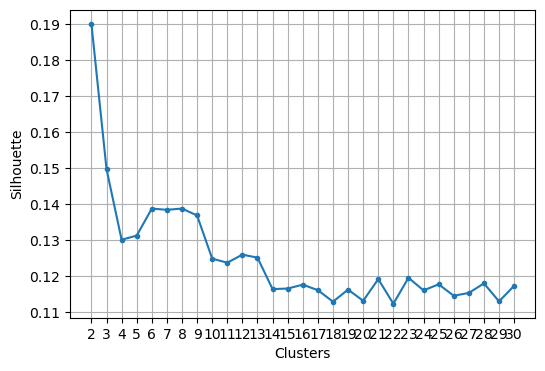

In [19]:
#Plotting Silhouette Coefficient with 'n' number of clusters (k)
plt.figure(figsize=(6,4))
plt.plot(range(2, max_k + 1), sil_list, marker='.')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.xticks(range(2, max_k + 1))
plt.grid()
plt.show()

<Figure size 600x400 with 0 Axes>

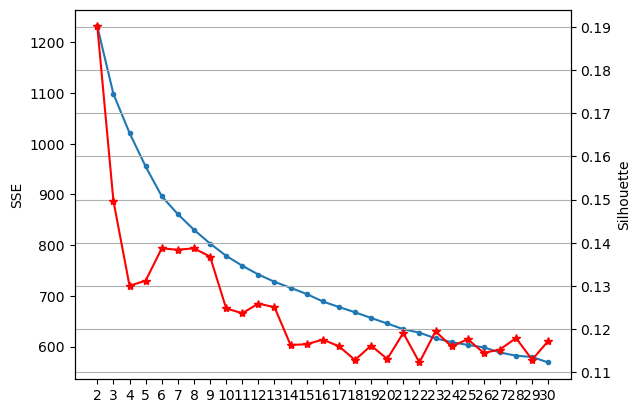

In [20]:
#Plotting Silhouette Coefficient 'n' number of clusters (k)
plt.figure(figsize=(6,4))
fig, ax1 = plt.subplots()

ax1.plot(range(2, max_k + 1), sse_list, marker='.')
ax1.set_ylabel('SSE')

ax2 = ax1.twinx()
ax2.plot(range(2, max_k + 1), sil_list, marker='*', c='r')
ax2.set_ylabel('Silhouette')

plt.xticks(range(2, max_k + 1))
plt.xlabel('k')
plt.grid()
plt.show()

### We decided to choose 6 clusters beacuse it has the higher Silhouette Coefficient and a relatively low SSE

In addition to higher Silhouette Coefficient score and relatively low SSE, with this k value it is possible to notice that all 6 different clusters are well balanced.

In [21]:
kmeans = KMeans(n_clusters= 6, n_init=100, max_iter=300, random_state=0)
kmeans.fit_predict(train_data)

array([0, 3, 0, ..., 4, 2, 4], dtype=int32)

In [22]:
kmeans.inertia_

896.3554282851516

In [23]:
silhouette_score(D, kmeans.labels_, metric='precomputed')

0.13869890544490926

In [24]:
labels, sizes = np.unique(kmeans.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(dfnaf)))

Cluster 0, size 292 (0.12)
Cluster 1, size 498 (0.20)
Cluster 2, size 442 (0.18)
Cluster 3, size 383 (0.16)
Cluster 4, size 422 (0.17)
Cluster 5, size 415 (0.17)


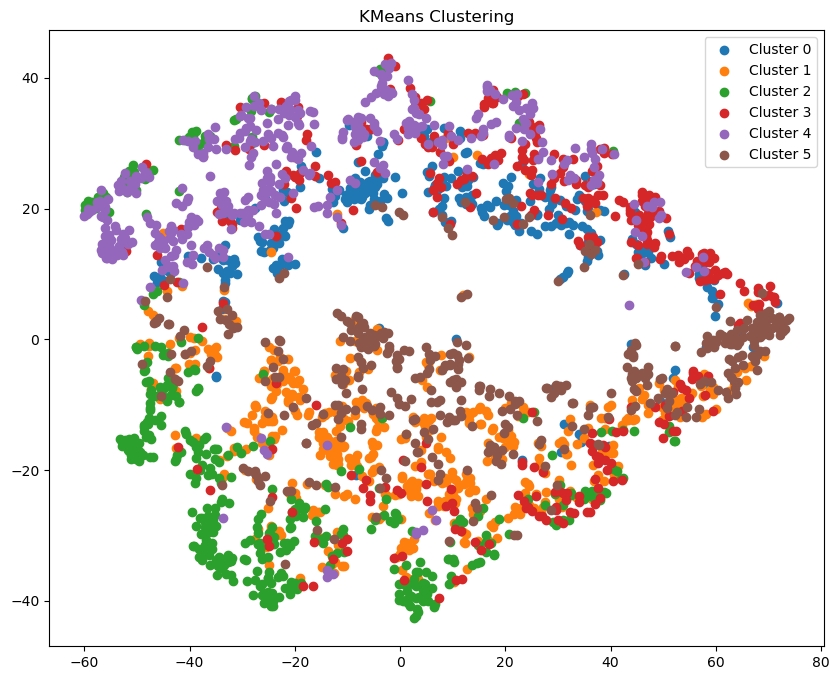

In [25]:
# Plotting the clusters with TSNE
df['kmeans_label'] = kmeans.labels_

X_tsne = tsne.fit_transform(dfnaf.values)
X_tsne

plt.figure(figsize=(10, 8))
for i in range(6):  # Assuming 6 clusters
    cluster_points = X_tsne[df['kmeans_label'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

plt.title('KMeans Clustering')
plt.legend()
plt.show()

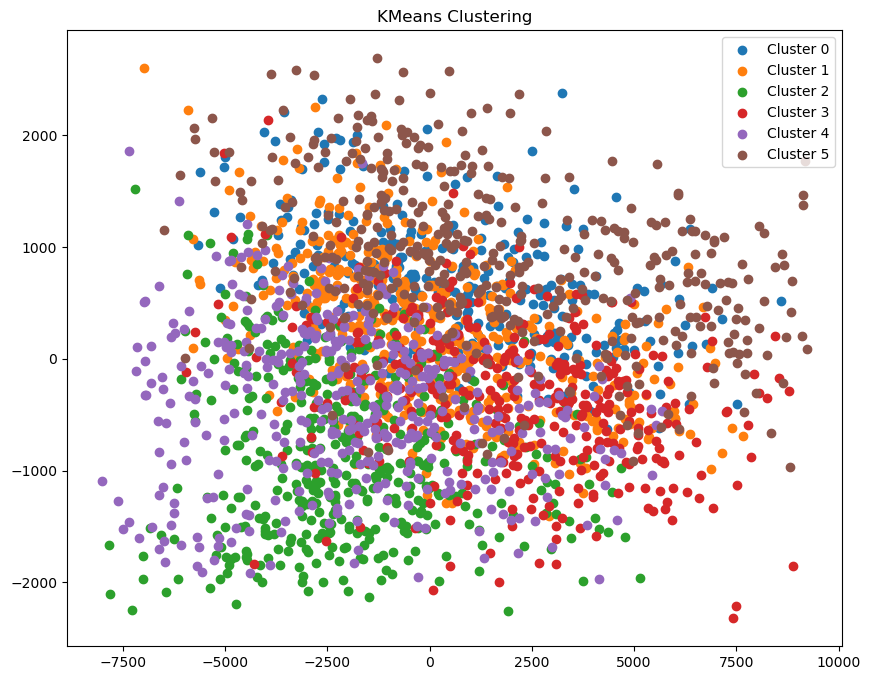

In [26]:
# Plotting the clusters with PCA
X_pca = pca.fit_transform(dfnaf.values)
X_pca

plt.figure(figsize=(10, 8))
for i in range(6):  # Assuming 6 clusters
    cluster_points = X_pca[df['kmeans_label'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

plt.title('KMeans Clustering')
plt.legend()
plt.show()

### Saving best kmeans in our DataFrame

In [27]:
df['kmeans_label'] = kmeans.labels_

In [28]:
vocal_xt2 = pd.crosstab(df['vocal_channel'], df['kmeans_label'])
vocal_xt2 = pd.crosstab(df['kmeans_label'], df['vocal_channel'])
vocal_xt2

vocal_channel,0,1
kmeans_label,,
0,61,231
1,208,290
2,423,19
3,239,144
4,321,101
5,183,232


In [29]:
sex_xt2 = pd.crosstab(df['sex'], df['kmeans_label'])
sex_xt2 = pd.crosstab(df['kmeans_label'], df['sex'])
sex_xt2

sex,0,1
kmeans_label,,
0,50,242
1,350,148
2,359,83
3,93,290
4,128,294
5,268,147


In [30]:
emotion_xt2 = pd.crosstab(df['emotion'], df['kmeans_label'])
emotion_xt2 = pd.crosstab(df['kmeans_label'], df['emotion'])
emotion_xt2

emotion,angry,calm,disgust,fearful,happy,neutral,sad,surprised
kmeans_label,,,,,,,,
0,19,87,13,39,43,22,63,6
1,46,90,36,78,74,47,102,25
2,25,86,57,31,50,53,75,65
3,121,0,26,77,86,6,29,38
4,18,95,44,34,40,56,82,53
5,147,18,16,117,83,4,25,5


## Our clusterings come this way after Kmeans

After selecting the best hyperparameters values for our clusters, we decided that evaluating our analysis we need to show the distribution of the categorical features ('sex', 'vocal_channel', 'emotion'). We discover a better separation for 'vocal_channel' values, where the clusters are more pure with respect to variables, we can apreciate this in clusters 0, 1, 5. Another remarcable result is for the 'sex' variable, where purest clusters are 0, 3, 5. On the contrary, with regard to 'emotion' we cannot se a proper separation.

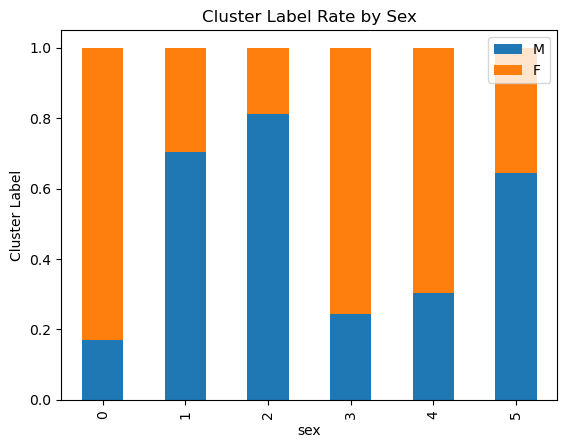

In [31]:
#Crosstab 'sex'
sex_xt2_pct = sex_xt2.div(sex_xt2.sum(1).astype(float), axis=0)
sex_xt2_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by Sex')
plt.xlabel('sex')
plt.ylabel('Cluster Label')
plt.legend(['M','F'])
plt.show()

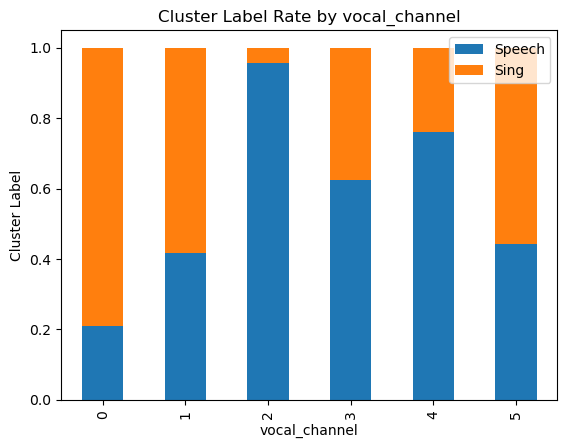

In [32]:
#Crosstab 'vocal_channel'
vocal_xt2_pct = vocal_xt2.div(vocal_xt2.sum(1).astype(float), axis=0)
vocal_xt2_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by vocal_channel')
plt.xlabel('vocal_channel')
plt.ylabel('Cluster Label')
plt.legend(['Speech','Sing'])
plt.show()

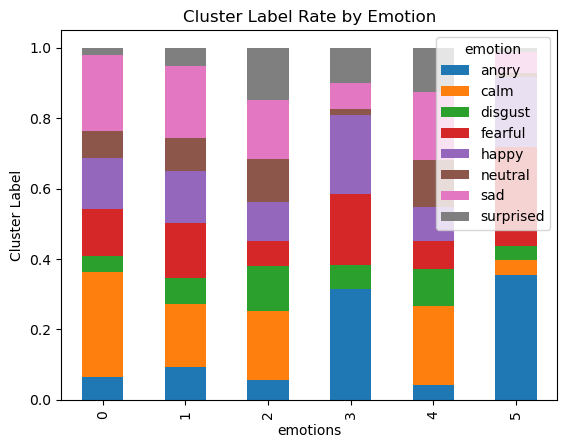

In [33]:
#Crosstab 'emotion'
emotion_xt2_pct = emotion_xt2.div(emotion_xt2.sum(1).astype(float), axis=0)
emotion_xt2_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by Emotion')
plt.xlabel('emotions')
plt.ylabel('Cluster Label')
plt.show()

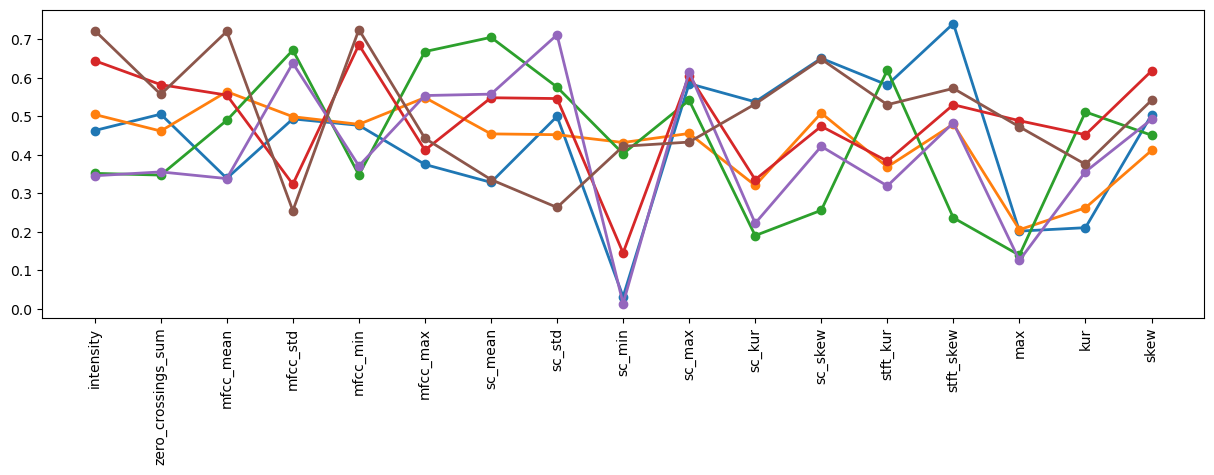

In [35]:
#Plotting the final value of the normalized features for each cluster with parallel coordinates graph
plt.figure(figsize=(15,4))
for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, 17), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=2, marker='o')
plt.xticks(range(0, 17), list(dfnaf.columns),rotation = 90)
plt.show()

## Analysis by density-based clustering

Before clustering we normalized the features to bring them to a similar scale, because DBSCAN uses different types of distances methods, as seen in metric. To find the best eps value we decided to use the knee point method to obtain the best result for eps = 0.54. After we have plotted the variation of the curve with different values of min points, and decided to select 4 (as standard) min points because the trend did not have a significant change for different values of min points. Lastly we've reported the visualization of normalized data for each cluster.

In [36]:
# density based clustering
print('dbscan')

dbscan = DBSCAN(eps=0.5, min_samples=4, metric='euclidean')
dbscan.fit(train_data)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, dbscan.labels_))

dbscan
labels {-1: 220, 0: 2219, 1: 4, 2: 5, 3: 4, 4: 0}
silhouette 0.0525233004475083


In [37]:
labels, sizes = np.unique(dbscan.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(train_data)))

Cluster -1, size 220 (0.09)
Cluster 0, size 2219 (0.90)
Cluster 1, size 4 (0.00)
Cluster 2, size 5 (0.00)
Cluster 3, size 4 (0.00)


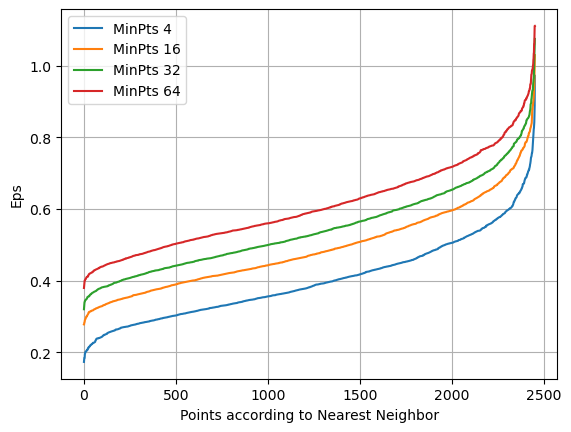

In [38]:
#Plotting the trend for different MinPts
for min_pts in [4, 16, 32, 64]:
    min_pts_distance = list()

    for i in range(len(train_data)):
        neigh_idx = np.argsort(D[i])[min_pts]
        min_pts_distance.append(D[i, neigh_idx])

    plt.plot(range(len(train_data)), sorted(min_pts_distance), label='MinPts %s' % min_pts)
plt.xlabel('Points according to Nearest Neighbor')
plt.ylabel('Eps')
plt.yticks()
plt.grid()
plt.legend()
plt.show()

0.5153305316783106


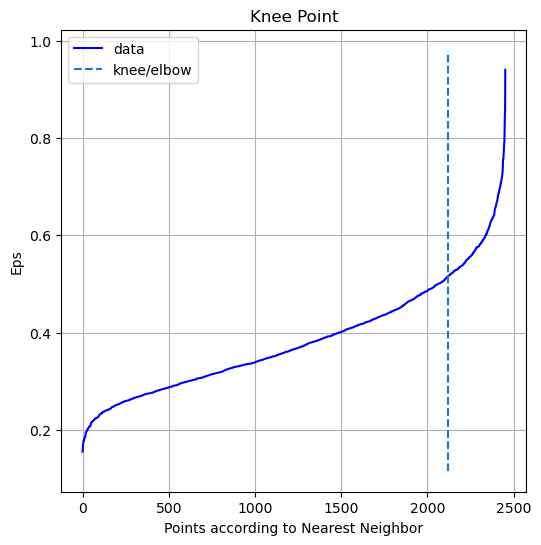

In [39]:
#Finding knee point and then use it to refit DBSCAN
nearest_neighbors = NearestNeighbors(n_neighbors=4)
neighbors = nearest_neighbors.fit(train_data)
distances, indices = neighbors.kneighbors(train_data)

distances = np.sort(distances[:,3], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')


knee.plot_knee()
plt.xlabel("Points according to Nearest Neighbor")
plt.ylabel("Eps")
plt.grid()

print(distances[knee.knee])


In [40]:
#Applyng DBSCAN to data
dbscan = DBSCAN(eps=distances[knee.knee], min_samples=4, metric='euclidean')
dbscan.fit(train_data)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

#Printing Silhouette Coefficient score and labels
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, dbscan.labels_))

labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.06194262082399004


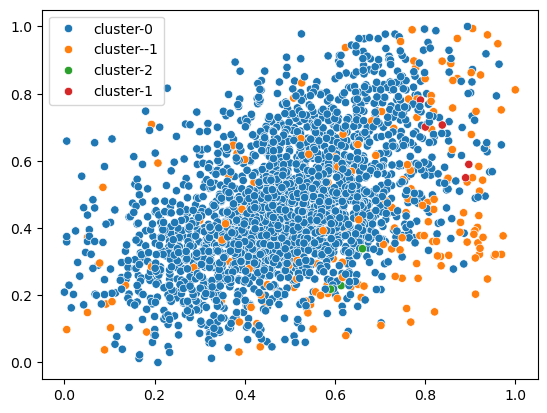

In [41]:
#Plotting divided by cluster
labels = dbscan.labels_
sns.scatterplot(x=train_data[:, 0], y=train_data[:, 1], hue=["cluster-{}".format(x) for x in labels])
plt.show()

### Saving best DBSCAN in our DataFrame

In [42]:
df['dbscan_labels']=dbscan.labels_

# Analysis by hierarchical clustering


After plotting the dendrogram for the chosen features, for a better comprehension of our data we decided to cut it at t= 1.9 to form flat clusters.

In [43]:
#Calculating distances (sparse version)
Ds = pdist(train_data)

In [44]:
#Dendrogram stored in memory (dendrogram links)
links = linkage(Ds, method = 'complete')

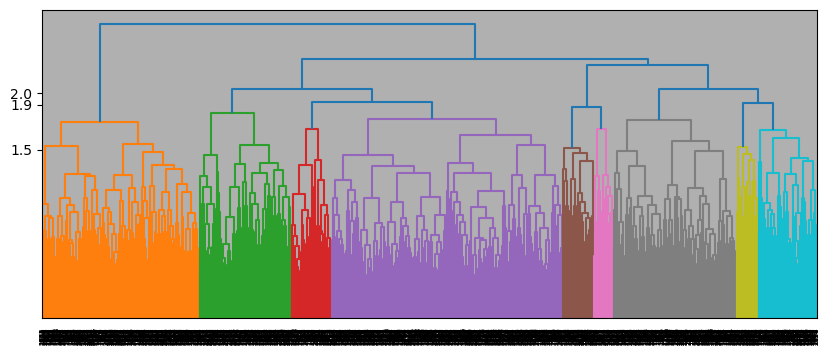

In [45]:
#Link to dendrogram to get the graph
plt.figure(figsize=(10,4))
plt.yticks([1.5,1.9,2])
plt.grid()
res = dendrogram(links)

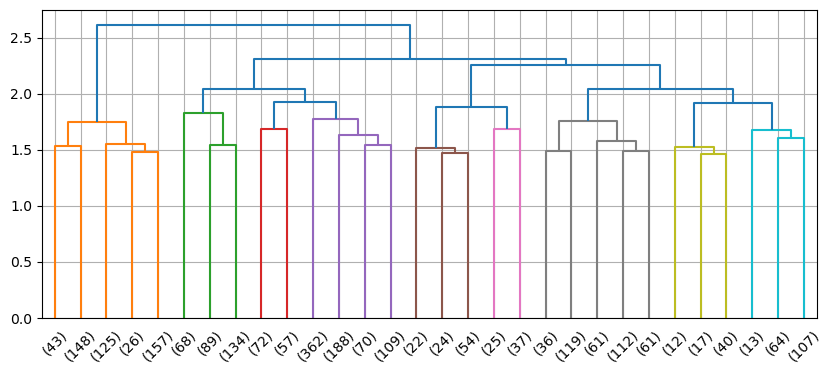

In [46]:
#Display only the top part of the dendrogram with lastp
plt.figure(figsize=(10,4))
res = dendrogram(links,truncate_mode="lastp")
plt.grid()
plt.show()

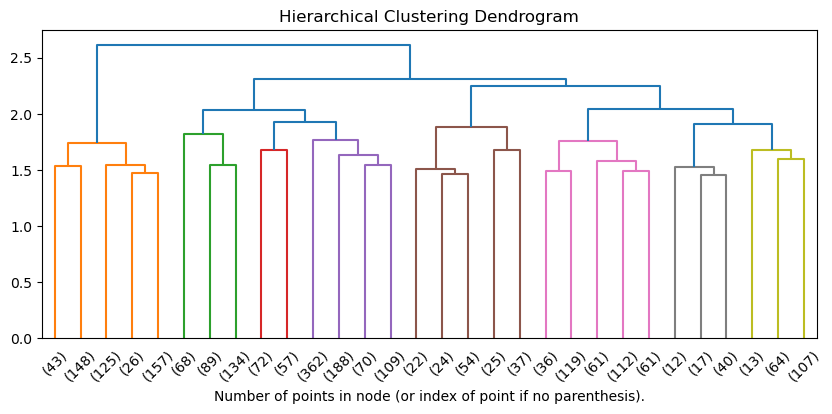

In [47]:
#Plotting the dendrogram with color_threshold=1.9
plt.figure(figsize=(10,4))
plt.title("Hierarchical Clustering Dendrogram")
res = dendrogram(links,truncate_mode="lastp",color_threshold=1.9)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [48]:
#Actual cut on t=1.9
hier_labels = fcluster(links,t=1.9,criterion='distance')

In [49]:
#Size of each cluster
labels, sizes = np.unique(hier_labels, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(train_data)))

Cluster 1, size 499 (0.20)
Cluster 2, size 291 (0.12)
Cluster 3, size 129 (0.05)
Cluster 4, size 729 (0.30)
Cluster 5, size 162 (0.07)
Cluster 6, size 389 (0.16)
Cluster 7, size 69 (0.03)
Cluster 8, size 184 (0.08)


In [50]:
#Calculate centroids
hier_centers = list()
for l in sorted(np.unique(hier_labels)):
    if l == -1:
        continue
    hier_centers.append(np.mean(train_data[hier_labels == l], axis=0))
hier_centers = np.array(hier_centers)

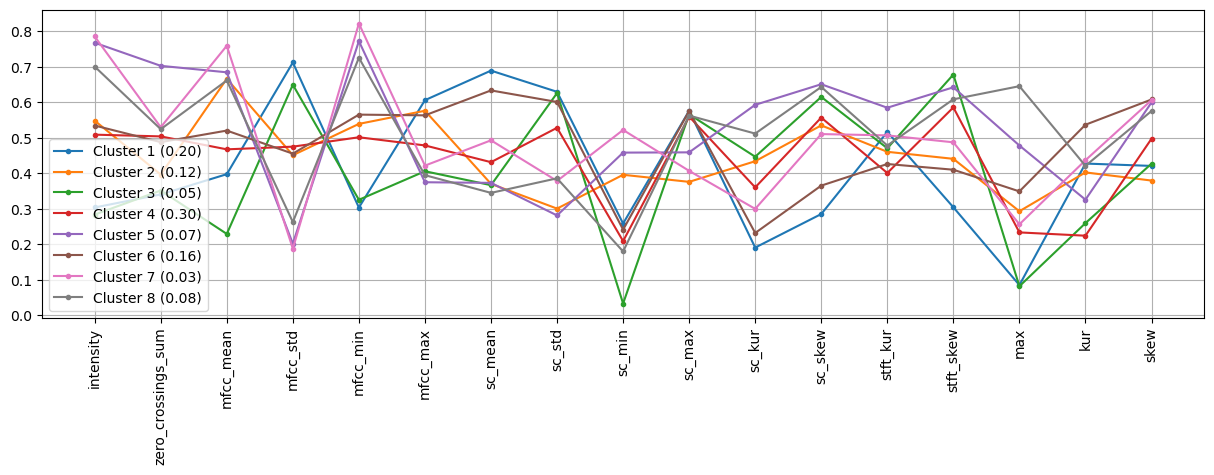

In [51]:
#Plotting with a parallel coordinates graph
labels, sizes = np.unique(hier_labels, return_counts=True)
plt.figure(figsize=(15,4))
for l in np.unique(hier_labels):
    if l == -1:
        continue
    plt.plot(dfnaf.columns, hier_centers[l-1], marker='.',
             label='Cluster %s (%.2f)' % (l, sizes[l-1]/len(train_data)))
plt.xticks(rotation = 90)
plt.grid()
plt.legend()
plt.show()

In [52]:
silhouette_score(train_data, hier_labels)

0.061943486436058

In [53]:
#Setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='complete')
model = model.fit(train_data)

In [54]:
# Create linkage matrix and then plot the dendrogram
def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

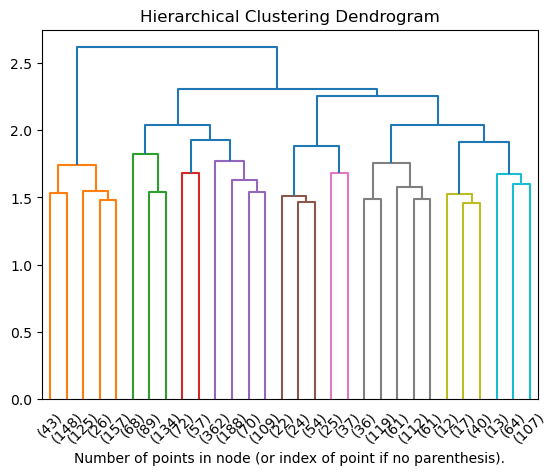

In [55]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

To evaluate the best performances of the hierarchical clustering with respect to linkage criteria and metrics, we wrote a code to analyse the different values of Silhouette Coefficient and the distribution of each record. The highest Silhouette score was found with the use of  single and manhattan, but after plotting it we discovered that it was not the best option. So we decided to utilize ward-euclidean for it's better distribution.
After plotting the dendrogram we decided that the proper nuber of clusters would have been 6, because the clusters looked well balanced so the color_threshold was performed at 10.

In [56]:
# Choose the linkage and metric criterion
linkage_criteria = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan', 'cosine', 'minkowski']

# Create AgglomerativeClustering instances with different linkage criteria
for link in linkage_criteria:
    for metric in metrics:
        try:
            model = AgglomerativeClustering(n_clusters=6, linkage=link,  metric=metric)
            # Fit and use the model as needed
            model.fit(train_data)
            print(link, metric)
            print('labels', dict(zip(bins, hist)))
            print('silhouette', silhouette_score(train_data, model.labels_))
        except ValueError:
            continue


ward euclidean
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.11237275553711133
complete euclidean
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.0744658588894875
complete manhattan
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.05088666252511479
complete cosine
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.037818373026257825
complete minkowski
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.0744658588894875
average euclidean
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.11830038656284408
average manhattan
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.08149454053446514
average cosine
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.05106413332264724
average minkowski
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.11830038656284408
single euclidean
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.04211614132166494
single manhattan
labels {-1: 186, 0: 2258, 1: 5, 2: 3, 3: 0}
silhouette 0.097

In [57]:
#Distribution for each cluster and Silhouette coefficient with 'euclidean' distance
ward = AgglomerativeClustering(n_clusters=6, linkage='ward', metric='euclidean')
ward.fit(train_data)

hist, bins = np.histogram(ward.labels_, bins=range(0, len(set(ward.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, ward.labels_))

labels {0: 562, 1: 500, 2: 523, 3: 292, 4: 230, 5: 345}
silhouette 0.11237275553711133


In [58]:
Ds = pdist(train_data, metric='euclidean')

In [59]:
links = linkage(Ds, method = 'ward')

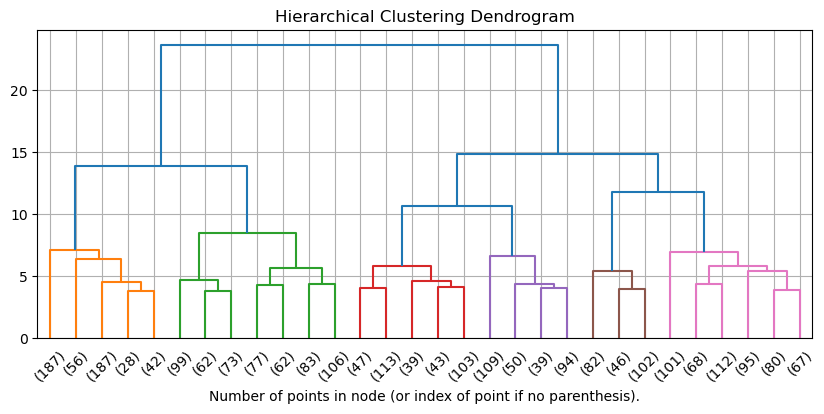

In [60]:
#Plotting the dendrogram with color_threshold=12
plt.figure(figsize=(10,4))
plt.title("Hierarchical Clustering Dendrogram")
res = dendrogram(links,truncate_mode="lastp",color_threshold=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.grid()
plt.show()

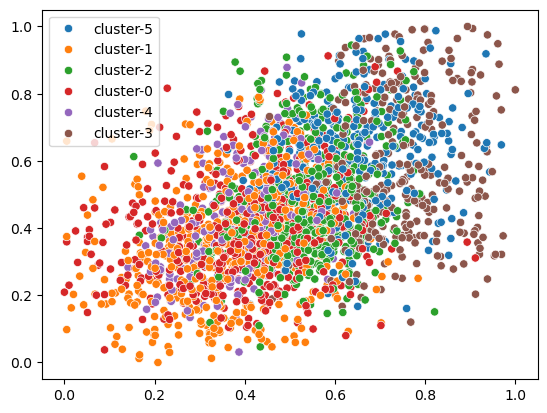

In [61]:
#Plotting data divided by cluster with 'euclidean' distance
labels = ward.labels_
sns.scatterplot(x=train_data[:, 0], y=train_data[:, 1], hue=["cluster-{}".format(x) for x in labels])
plt.show()

### Saving best Hierarchical Clustering in our DataFrame

In [62]:
ward.labels_
df['ward_labels'] = ward.labels_

# Clustering Conclusions

After our clustering analysis, we saw that the DBSCAN algorithm has a very bad performances on this dataset. Therefore, we decided to take into consideration KMeans and Hierarchical clustering. As we can see, the results that we obtained for the sse and bss score for those two methods are pretty similar, so we decided to analyze the crosstab plots that we obtained with respect to categorical feature.

After analyzing every type of clustering and searching for the best parameters, we conclude that the best clustering, for our type of data, is K-Means. Not only does it have a lower SSE indicating that points are closer together, also as we can see on our crosstab we have almost pure clusters of the features Sex and Vocal Channel.

In [63]:
def sse_score(X, labels, return_centers=False):
    cluster_centers = list()
    tot_distance = 0.0
    for l in np.unique(labels):
        if l == -1:
            continue
        cluster = X[labels == l]
        center = cluster.mean(axis=0)
        dist = cdist(cluster, center.reshape(1,-1))
        tot_distance += dist.sum()
        cluster_centers.append(center)
    cluster_centers = np.array(cluster_centers)
    if return_centers:
        return tot_distance, cluster_centers

    return tot_distance

def bss_score(X, cluster_centers):
    data_center = X.mean(axis=0)
    dist = cdist(cluster_centers, data_center.reshape(1,-1))
    return dist.sum()

In [64]:
for alg in ['kmeans_label','dbscan_labels','ward_labels']:
    labels = df[alg]
    sse, cluster_centers = sse_score(train_data, labels, return_centers=True)
    bss = bss_score(train_data, cluster_centers)
    print('%s \t SSE %.2f  BSS %.2f' % (alg, sse, bss))

kmeans_label 	 SSE 1432.43  BSS 3.11
dbscan_labels 	 SSE 1696.26  BSS 1.98
ward_labels 	 SSE 1485.21  BSS 3.07


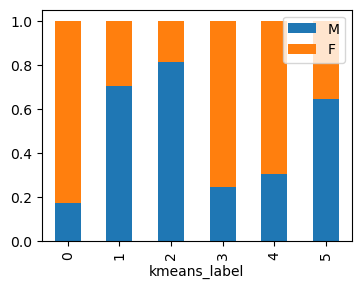

In [65]:
ct = pd.crosstab(df['kmeans_label'], df['sex'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.legend(['M','F'])
plt.show()

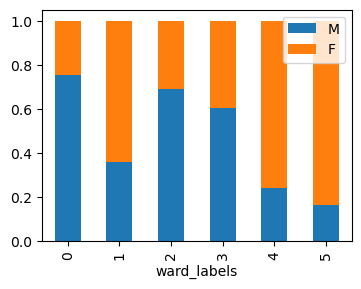

In [66]:
ct = pd.crosstab(df['ward_labels'], df['sex'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.legend(['M','F'])
plt.show()

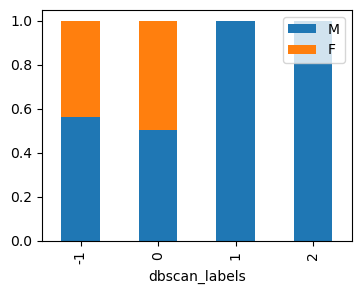

In [67]:
ct = pd.crosstab(df['dbscan_labels'], df['sex'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.legend(['M','F'])
plt.show()

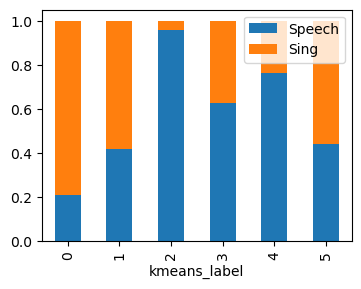

In [68]:
ct = pd.crosstab(df['kmeans_label'], df['vocal_channel'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.legend(['Speech','Sing'])
plt.show()

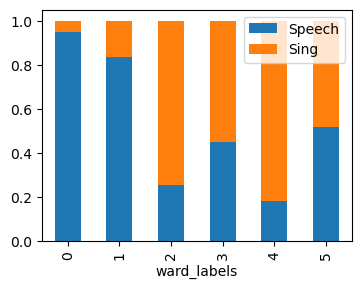

In [69]:
ct = pd.crosstab(df['ward_labels'], df['vocal_channel'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.legend(['Speech','Sing'])
plt.show()

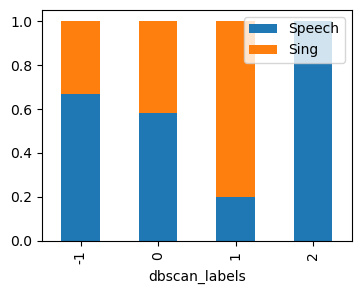

In [70]:
ct = pd.crosstab(df['dbscan_labels'], df['vocal_channel'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.legend(['Speech','Sing'])
plt.show()

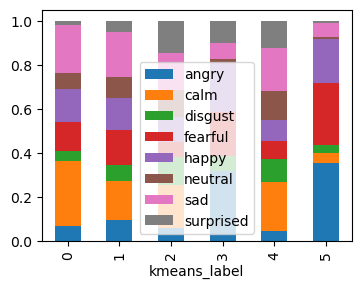

In [71]:
ct = pd.crosstab(df['kmeans_label'], df['emotion'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.legend()
plt.show()

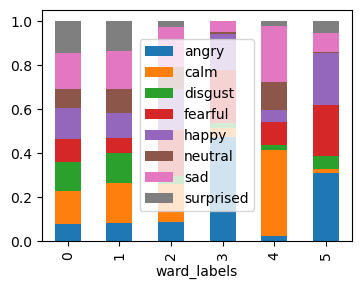

In [72]:
ct = pd.crosstab(df['ward_labels'], df['emotion'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.legend()
plt.show()

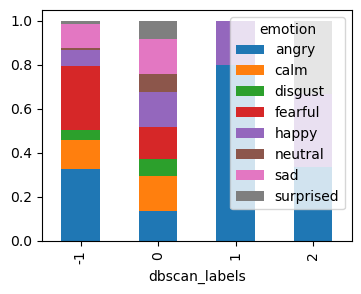

In [73]:
ct = pd.crosstab(df['dbscan_labels'], df['emotion'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))

plt.show()